In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
crypto_data = pd.read_csv("data/crypto_30min_filled_missing_value(ffill).csv").set_index("date")

In [ ]:
btc_price = crypto_data["BTC"]

In [ ]:
prices = btc_price.values

# **Normalize Data**

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices.reshape(-1, 1))

# **Length for Prediction**

In [ ]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 48  # Use past 24 hours to predict the next 30-min price
X, y = create_sequences(scaled_prices, seq_length)

# **Split ito Train and Test Sets**

In [ ]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert to PyTorch tensors
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)


# **Batching**

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
dataset = TensorDataset(X_train,y_train)
batch_size = 24
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# **Bi-LSTM**

In [ ]:
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)  # Multiply by 2 for bidirection

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)  # 2 for bidirection
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Output of the last time step
        return out


# **Initialize the Model**

In [ ]:
input_size = 1  # Only one feature (BTC price)
hidden_size = 50
num_layers = 2
output_size = 1

model = BiLSTM(input_size, hidden_size, num_layers, output_size)


# **Loss and Optimizer Functions**

In [ ]:
loss_f = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# **Train the Model**

In [ ]:
X_train.shape

torch.Size([57484, 48, 1])

In [ ]:
num_epochs = 4
loss_epoch = []
for epoch in range(num_epochs):
  model.train()
  for batch_idx, (batch_X, batch_y) in enumerate(dataloader):
    outputs = model(batch_X)
    loss = loss_f(outputs, batch_y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_epoch.append(loss.item())

  print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {np.mean(loss_epoch):.4f}')


Epoch [1/4], Loss: 0.0000
Epoch [2/4], Loss: 0.0000
Epoch [3/4], Loss: 0.0000
Epoch [4/4], Loss: 0.0000


# **Testing**

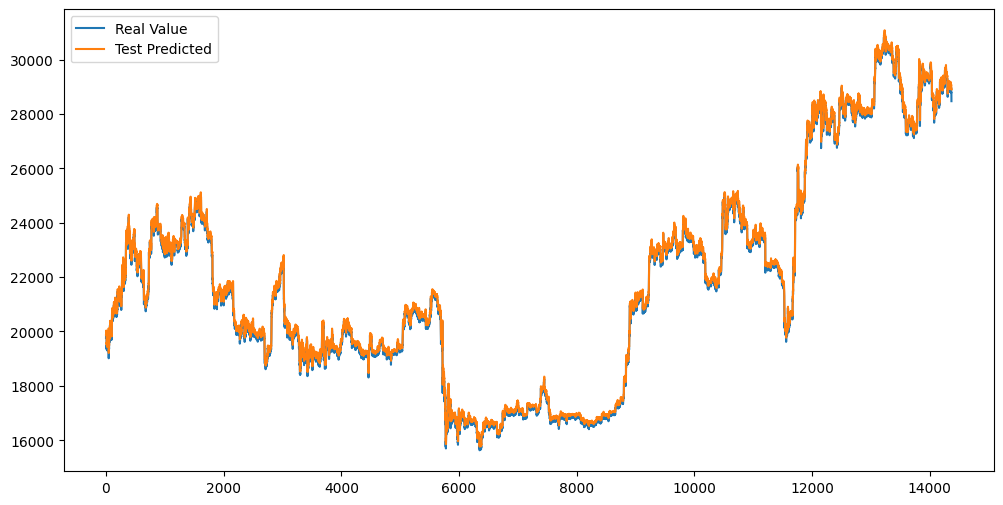

In [ ]:
model.eval()
with torch.no_grad():
    test_pred = model(X_test).cpu().numpy()

test_pred = scaler.inverse_transform(test_pred)
y_test_actual = scaler.inverse_transform(y_test.cpu().numpy().reshape(-1, 1))
# y_train_inverse = scaler.inverse_transform(y_train.cpu().numpy().reshape(-1,1))

plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test_actual)), y_test_actual, label='Real Value')
plt.plot(range(len(test_pred)), test_pred, label='Test Predicted')
plt.legend()
plt.show()

In [ ]:
rmse = np.sqrt(np.mean((y_test_actual - test_pred) ** 2))

In [ ]:
mae  = np.mean(np.abs(y_test_actual - test_pred))

In [ ]:
mae

122.898674

# **Using Moving Average**

In [ ]:
moving_average = []

for i in X_test:
  moving_average.append(torch.mean(i))

In [ ]:
test_pred_mav = scaler.inverse_transform(np.asarray(moving_average).reshape(-1,1))

In [ ]:
rmse_mav = np.sqrt(np.mean((y_test_actual - test_pred_mav) ** 2))

In [ ]:
rmse_mav

357.17102

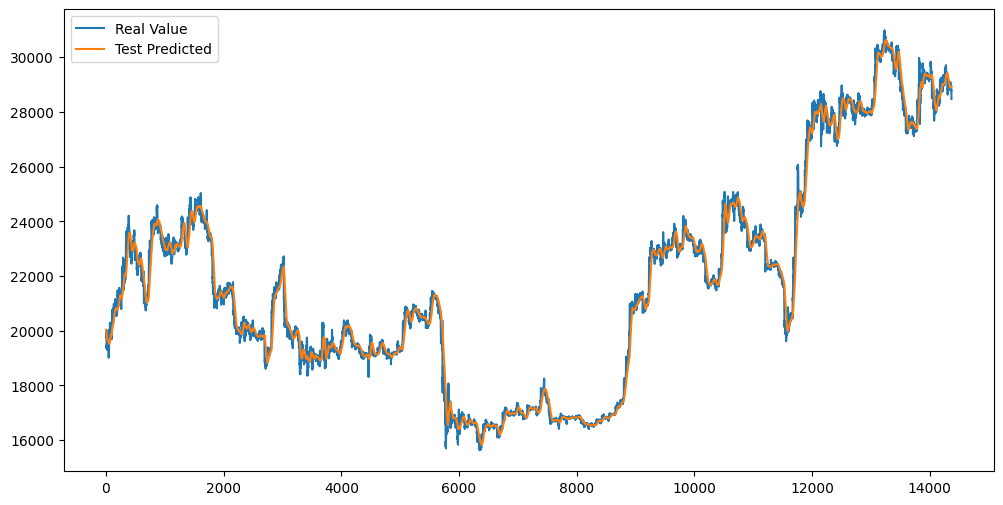

In [ ]:
model.eval()
with torch.no_grad():
    test_pred = model(X_test).cpu().numpy()

test_pred = scaler.inverse_transform(test_pred)
y_test_actual = scaler.inverse_transform(y_test.cpu().numpy().reshape(-1, 1))
# y_train_inverse = scaler.inverse_transform(y_train.cpu().numpy().reshape(-1,1))

plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test_actual)), y_test_actual, label='Real Value')
plt.plot(range(len(test_pred_mav)), test_pred_mav, label='Test Predicted')
plt.legend()
plt.show()